In [1]:
%tensorflow_version 2.x
import tensorflow as tf

# layers
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Flatten
# model
from tensorflow.keras.models import Model
# optimizers
from tensorflow.keras.optimizers import Adam, SGD

# additional imports
import numpy as np # linear algebra
import pandas as pd # data manipulation
import matplotlib.pyplot as plt # data visualisation

TensorFlow 2.x selected.


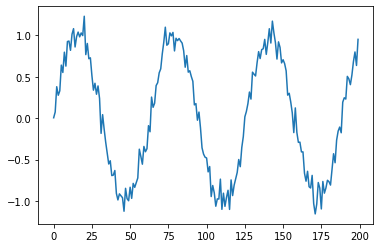

In [2]:
# make the data                     # adding noise
series = np.sin(0.1*np.arange(200)) + np.random.randn(200)*0.1

# plot the data
plt.plot(series)
plt.show()

In [25]:
# build the dataset
T = 10
D = 1
X = []
Y = []

for t in range(len(series) -T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)
X = np.array(X).reshape(-1, T, 1) # Now the data should be NxTxD to be passed into RNN
Y = np.array(Y)
N = len(X)
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (190, 10, 1) Y.shape (190,)


In [32]:
# Now try autoregressive RNN model
i = Input(shape=(T, 1))
# SimpleRNN has the default activation function as tanh
# but you can specify something else like ReLU
# Also you can pass None as activation, this'll reduce RNN into linear model.
# Also the data we generated is linear hence we shall pass None as activation function. Without activation function, RNN will reduce to linear model
# and it will work like the model in: https://colab.research.google.com/drive/1pD2k_5gIoLNTYoh_dLcQOKSiMrtpQ17_
x = SimpleRNN(5)(i)
x = Dense(1)(x)
model = Model(i,x)
model.compile(loss = 'mse', optimizer = Adam(lr = 0.1))

# Train the RNN
r = model.fit( 
    X[:-N//2], Y[:-N//2], # Using first half as a training data
    validation_data = (X[-N//2:], Y[-N//2:]), # using last half as validation
    epochs = 100
)

Train on 95 samples, validate on 95 samples
Epoch 1/100
95/95 [==============================] - 1s 8ms/sample - loss: 0.5137 - val_loss: 0.1102
Epoch 2/100
95/95 [==============================] - 0s 252us/sample - loss: 0.1458 - val_loss: 0.1224
Epoch 3/100
95/95 [==============================] - 0s 230us/sample - loss: 0.0939 - val_loss: 0.0548
Epoch 4/100
95/95 [==============================] - 0s 242us/sample - loss: 0.0601 - val_loss: 0.0479
Epoch 5/100
95/95 [==============================] - 0s 236us/sample - loss: 0.0604 - val_loss: 0.0388
Epoch 6/100
95/95 [==============================] - 0s 244us/sample - loss: 0.0641 - val_loss: 0.0460
Epoch 7/100
95/95 [==============================] - 0s 239us/sample - loss: 0.0532 - val_loss: 0.0438
Epoch 8/100
95/95 [==============================] - 0s 262us/sample - loss: 0.0459 - val_loss: 0.0325
Epoch 9/100
95/95 [==============================] - 0s 267us/sample - loss: 0.0361 - val_loss: 0.0341
Epoch 10/100
95/95 [===========

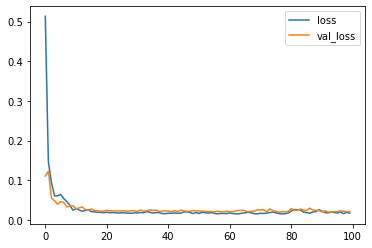

In [33]:
# now plot the results
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

In [34]:
# 'wrong' forecast using true targets
validation_target = Y[-N//2:]
validation_predictions = []

i = -N//2
while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1, -1, 1))[0,0] # 1x1 array -> scalar
  i += 1

  validation_predictions.append(p)
''' 
This kind of forecasting is wrong because it uses every X on the
dataset. So this isn't the correct way to do forecasting.
In the correct way,
forecasting starts by last X value and continues to predict next value
using its own PREDICTIONS. Not every X like this approach 
'''

" \nThis kind of forecasting is wrong because it uses every X on the\ndataset. So this isn't the correct way to do forecasting.\nIn the correct way,\nforecasting starts by last X value and continues to predict next value\nusing its own PREDICTIONS. Not every X like this approach \n"

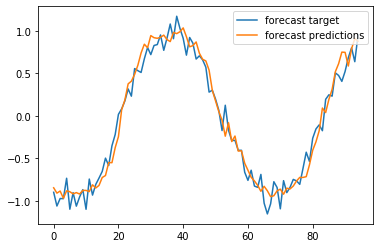

In [35]:
# plot the loss
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast predictions')
plt.legend()
plt.show()

In [0]:
# correct way of doing forecasting which uses only self-predictions for making future predictions
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1, 1))[0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

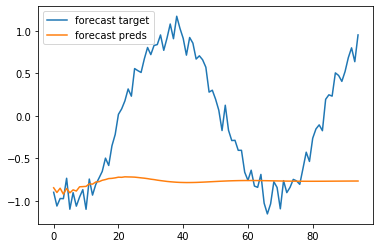

In [37]:
# plot the loss
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast preds')
plt.legend()
plt.show()

In [0]:
# So we can say that RNN doesn't works well on noisy data
# I guess what we've created isn't even a model
# it just takes last value to predict the next one
# so we can say that RNN is not optimal or needs to be tuned 
# in order to work efficiently on this problem